# 01.01-maj-extract-test-scores

Mitchell Joseph
<br>Created: 2022-11-22</br>
Last Modified: 2022-11-22

We revisit the original databases to extract out just the necessary columns and ignore all missing values. 
New .csv file is created called `data/01-raw/test_scores.csv`

In [67]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def run_query(db_path, query):
    """Query a database and return a pandas DataFrame."""
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

## High School
We'll start by extracting just the SAT scores from the HIGH SCHOOL database

In [12]:
hs_path = "../data/00-external/HIGH_SCHOOL.db"

In [40]:
# ACTComposite 
query_test_scores = """
SELECT [SubjectI.D.] as SUBJID, SATMath, SATWriting, SATVerbal FROM 'HIGH SCHOOL'
WHERE SATMath IS NOT NULL 
    AND SATWriting IS NOT NULL
    AND SATVerbal IS NOT NULL
    AND Surveyyear == 2010;
"""

hs_df = run_query(hs_path, query_test_scores)

In [41]:
print(hs_df.shape)
hs_df.head()

(104077, 4)


,SUBJID,SATMath,SATWriting,SATVerbal
0,884230,450,420,430
1,884232,430,430,470
2,884233,430,320,320
3,884247,560,540,580
4,884266,440,400,410


## Demographics

In [42]:
demo_path = "../data/00-external/DEMOGRAPHICS.db"

query_demographics = """
SELECT [SubjectI.D.] as SUBJID, State, [Yoursex:], [Race/EthnicityGroup] FROM DEMOGRAPHICS
WHERE Surveyyear == 2010
    AND State IS NOT NULL
    AND [Yoursex:] != 0
    AND [Race/EthnicityGroup] IS NOT NULL;
"""

demo_df = run_query(demo_path, query_demographics)

In [43]:
demo_df.head()

,SUBJID,State,Yoursex:,Race/EthnicityGroup
0,884186,AL,Female,Black
1,884187,AL,Male,Black
2,884188,AL,Female,Black
3,884190,AL,Male,Two or more race/ethnicity
4,884191,AL,Male,Black


## TFS

In [91]:
tfs_path = "../data/00-external/TFS_CHOICE_2008_2010.db"

    #    CASE WHEN ACCPT1ST = 2 THEN 1 ELSE 0 END as ACCPT1ST
query_tfs = """
SELECT 
SUBJID,
CASE CHOICE
    WHEN 5 THEN -1
    WHEN 4 THEN -2
    WHEN 2 THEN -3
    WHEN 1 THEN -4
END AS CHOICE,
CASE ACCPT1ST
    WHEN 2 THEN 1
    ELSE 0
END AS ACCPT1ST
FROM CHOICE
WHERE Year == 2010
    AND CHOICE IS NOT NULL
    AND ACCPT1ST IS NOT NULL;
"""

tfs_df = run_query(tfs_path, query_tfs)

In [93]:
tfs_df['CHOICE'] = np.abs(tfs_df['CHOICE'])
tfs_df.head()

,SUBJID,CHOICE,ACCPT1ST
0,884186,2,1
1,884187,2,1
2,884188,4,1
3,884189,3,1
4,884190,2,0


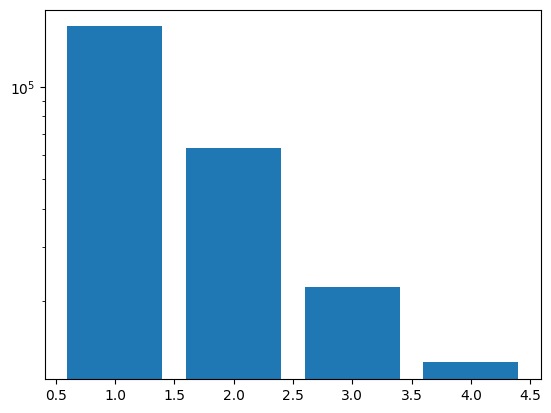

In [96]:
x = tfs_df['CHOICE'].value_counts().index
y = tfs_df['CHOICE'].value_counts().values
plt.bar(x, y)
plt.yscale('log')
plt.show();

## Merging

In [97]:
print(hs_df.shape)
print(demo_df.shape)
print(tfs_df.shape)

(104077, 4)
(248302, 4)
(255089, 3)


In [98]:
merged_df = pd.merge(hs_df, demo_df, how='left', on="SUBJID")

In [101]:
print(merged_df.shape)
merged_df.isna().sum()

(104077, 7)


SUBJID                    0
SATMath                   0
SATWriting                0
SATVerbal                 0
State                  3907
Yoursex:               3907
Race/EthnicityGroup    3907
dtype: int64

In [103]:
merged_df.dropna(inplace=True)
merged_df.shape

(100170, 7)

In [104]:
merged_df = pd.merge(merged_df, tfs_df, how='left', on='SUBJID')

In [106]:
merged_df.dropna(inplace=True)
print(merged_df.shape)

(98514, 9)


In [107]:
# merged_df.to_csv("../data/01-raw/test_scores.csv", index=False)